In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import notebook, tqdm
import seaborn as sns
from collections import Counter

In [2]:
root = "/mnt/12TB/suad_23"
imgs = list(sorted(os.listdir(os.path.join(root, "inputs"))))
# targets = list(sorted(os.listdir(os.path.join(root,
#                                 "semantic_annotations"))))
len(imgs)

1786

## Check image sizes

In [6]:
width = []
height = []

for file in tqdm(imgs):
    img = Image.open(root + "/inputs/"+file)
    img.load()
    w, h = img.size
    width.append(w)
    height.append(h)

100%|██████████| 1786/1786 [01:15<00:00, 23.63it/s]


In [11]:
Counter(height)

Counter({2200: 1431, 2150: 160, 2250: 195})

In [12]:
Counter(width)

Counter({1550: 1162, 1500: 430, 1400: 194})

<AxesSubplot: xlabel='width', ylabel='height'>

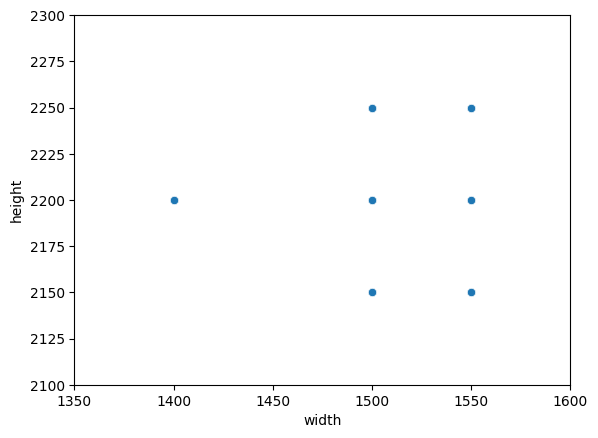

In [9]:
plt.xlim(min(width)-50, max(width)+50)
plt.ylim(min(height)-50, max(height)+50)
plt.xlabel("width")
plt.ylabel("height")
sns.scatterplot(x=width, y=height)